In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

#For proper display of all columns
from IPython.display import display
pd.options.display.max_columns = None

#Import warnings
import warnings
warnings.filterwarnings("ignore")
import gc

import statsmodels.api as sm

In [20]:
# Funtion to check the missing value count and percentage
def missing_val_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()
               ).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data


def get_box_plot(train):
    cont_cols = list(train._get_numeric_data().columns)
    fig, ax = plt.subplots(nrows=len(cont_cols) // 2 +
                           1, ncols=2, figsize=(10, 10))

    def func(x): return x.replace("_", " ").capitalize()
    cols_corrected = list(map(func, cont_cols))

    var_idx = 0

    for i in range(len(cont_cols) // 2 + 1):
        for j in range(2):
            try:
                sns.boxplot(train[cont_cols[var_idx]],
                            ax=ax[i][j], color="red")
                ax[i][j].set_xlabel(cols_corrected[var_idx])
                var_idx += 1
            except:
                break

    fig.suptitle("Box plots for outliers")


In [21]:
audiodf = pd.read_csv(os.path.join("input", "SpotifyAudioFeaturesApril2019.csv"))
print(audiodf.shape)
print(audiodf.columns)


# Creating a duration feature coverted to minutes for intuitive understanding
audiodf['duration_mins'] = audiodf['duration_ms'] / 60000

audiodf.drop(['duration_ms'],axis = 1, inplace = True)

(130663, 17)
Index(['artist_name', 'track_id', 'track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'popularity'],
      dtype='object')


**Duplicates checks as per track_id:**

In [22]:
print("Total Duplicates on the basis of tracks in the data" , audiodf[audiodf.duplicated(subset = 'track_id')].shape[0])

Total Duplicates on the basis of tracks in the data 337


**Lets look at the data statistics**

In [23]:
audiodf.describe([.1,.25,.5,.75,.9,.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
acousticness,130663.0,0.342500,0.345641,0.000000,0.002440,0.031600,0.203000,0.636000,0.93000,0.994000,0.996000
danceability,130663.0,0.581468,0.190077,0.000000,0.310000,0.459000,0.605000,0.727000,0.80900,0.919000,0.996000
energy,130663.0,0.569196,0.260312,0.000000,0.163000,0.396000,0.603000,0.775000,0.89400,0.987000,1.000000
instrumentalness,130663.0,0.224018,0.360328,0.000000,0.000000,0.000000,0.000149,0.440000,0.89300,0.969000,1.000000
key,130663.0,5.231894,3.602701,0.000000,0.000000,2.000000,5.000000,8.000000,10.00000,11.000000,11.000000
liveness,130663.0,0.194886,0.167733,0.000000,0.076200,0.097500,0.124000,0.236000,0.38300,0.895000,0.999000
loudness,130663.0,-9.974006,6.544379,-60.000000,-19.276000,-11.898000,-7.979000,-5.684000,-4.20900,-2.082000,1.806000
mode,130663.0,0.607739,0.488256,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1.000000
speechiness,130663.0,0.112015,0.124327,0.000000,0.032000,0.038900,0.055900,0.129000,0.29400,0.553000,0.966000
tempo,130663.0,119.473353,30.159636,0.000000,80.426000,96.014000,120.027000,139.642000,160.01800,190.196900,249.983000


In [24]:
audiodf.drop_duplicates().describe(include = ['O']).T

,count,unique,top,freq
artist_name,130663,34621,Johann Sebastian Bach,3621
track_id,130663,130326,0UBafqn0HVWRceDnOv2SZu,4
track_name,130663,108890,Intro,108


The stats looks fine however some of features might contain outlier which needs to be taken care of.

1) Majority of songs have a duration of 3.36 mins however some of the songs have the duration greater than 10 mins which needs to be treated. We can see the 99th percentile value to be close to 9.54 minutes. Lets remove all the songs greater than 10 mins of duration. 

2) In some tempo, time_signature is 0 which is not possible hence a potential anomoly in the data, hence such value will add noise to our model. We will be taking all songs with tempo & time_signature > 0

3) In some songs, duration is <1 min. As per our research songs have minimum duration of 1 mins else its not a song it is an abstract of the same. In addition some songs are greater than 10 mins of duration. As per our research we tried to search and found that some songs in the data are pure noise or podcasts which is out of scope for this analysis. Hence we will remove the songs with <1min of duration and greater than 10 mins of duration. 10 mins taken from 99 percentile of data split.

4) We also observe some songs to have 0 polularity. But our assumption is that songs can have 0 popularity hence keeping this feature as it is.

In [25]:
class Data_Preprocessing_SP(object):
    def __init__(self, data = None, subset_on = None, keep='first', song_duration_min_cutoff = 1, song_duration_max_cutoff = 10):
        self.data = data
        self.subset_on = subset_on
        self.keep = keep
        self.song_duration_min_cutoff = song_duration_min_cutoff
        self.song_duration_max_cutoff = song_duration_max_cutoff
    
    def duplicate_removal(self):
        """
        Removes duplicate on a primary key given
        """
        print("\n1. Duplicate Data Check & Removal if any")
        print("\nTotal duplicates on {} level are {}".format(self.subset_on, self.data[self.data.duplicated(subset = 'track_id')].shape[0]))
        
        self.data = self.data.drop_duplicates(subset = ['track_id'], keep = self.keep)
        
        print("\nTotal duplicates on {} level post treatment: {}".format(self.subset_on, self.data[self.data.duplicated(subset = 'track_id')].shape[0]))
        print("\nDuplicate Data treated")
        return self.data
        
    def intuitive_outlier_removal(self):
        print("\n2. Outlier removing engine started")
        print("\nRemoving outliers in duration (mins) of songs")
        
        self.data = self.data.query(f"duration_mins>={self.song_duration_min_cutoff} and duration_mins<={self.song_duration_max_cutoff}")
        
        print("\nRemoving songs with 0 tempo and time signature")
        
        self.data = self.data.query("tempo>0 and time_signature>0")
        
        print("\nIntuitive outliers removed")
        return self.data
    
    def runner(self):
        print("=====Data Cleaning on Song Polularity Data started====")
        self.data = self.duplicate_removal()
        self.data = self.intuitive_outlier_removal()
        print("\n=====Data Cleaning on Song Polularity Data completed====")
        return self.data

In [26]:
data_preprocess = Data_Preprocessing_SP(data = audiodf, subset_on = 'track_id', keep='first', song_duration_min_cutoff = 1, song_duration_max_cutoff = 10)
audiodf = data_preprocess.runner()

=====Data Cleaning on Song Polularity Data started====

1. Duplicate Data Check & Removal if any

Total duplicates on track_id level are 337

Total duplicates on track_id level post treatment: 0

Duplicate Data treated

2. Outlier removing engine started

Removing outliers in duration (mins) of songs

Removing songs with 0 tempo and time signature

Intuitive outliers removed

=====Data Cleaning on Song Polularity Data completed====


In [27]:
audiodf.head()

,artist_name,track_id,track_name,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,duration_mins
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15,3.972883
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0,3.580000
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56,2.315217
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0,2.089683
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0,2.066933


# EDA

                                 Numeric Features Distribution                                  


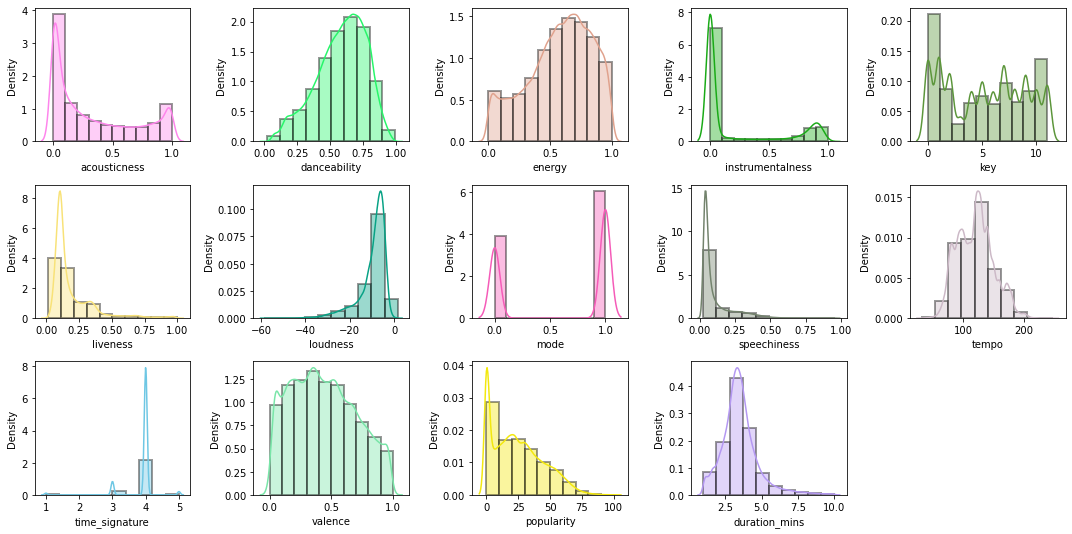

In [28]:
import math
print('\033[1mNumeric Features Distribution'.center(100))

n = 5
cols = audiodf.columns.tolist()[3:]
n_col = len(cols)

clr=['r','g','b','g','b','r']

plt.figure(
    figsize=[15,4*math.ceil(n_col/n)])

for i in range(n_col):
    plt.subplot(math.ceil(n_col/3),n,i+1)
    sns.distplot(audiodf[cols[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))

plt.tight_layout()
plt.show()

In [29]:
audiodf.columns

Index(['artist_name', 'track_id', 'track_name', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'popularity',
       'duration_mins'],
      dtype='object')

<AxesSubplot:title={'center':'Average Traits of Top-Moderately-Low popular Songs'}>

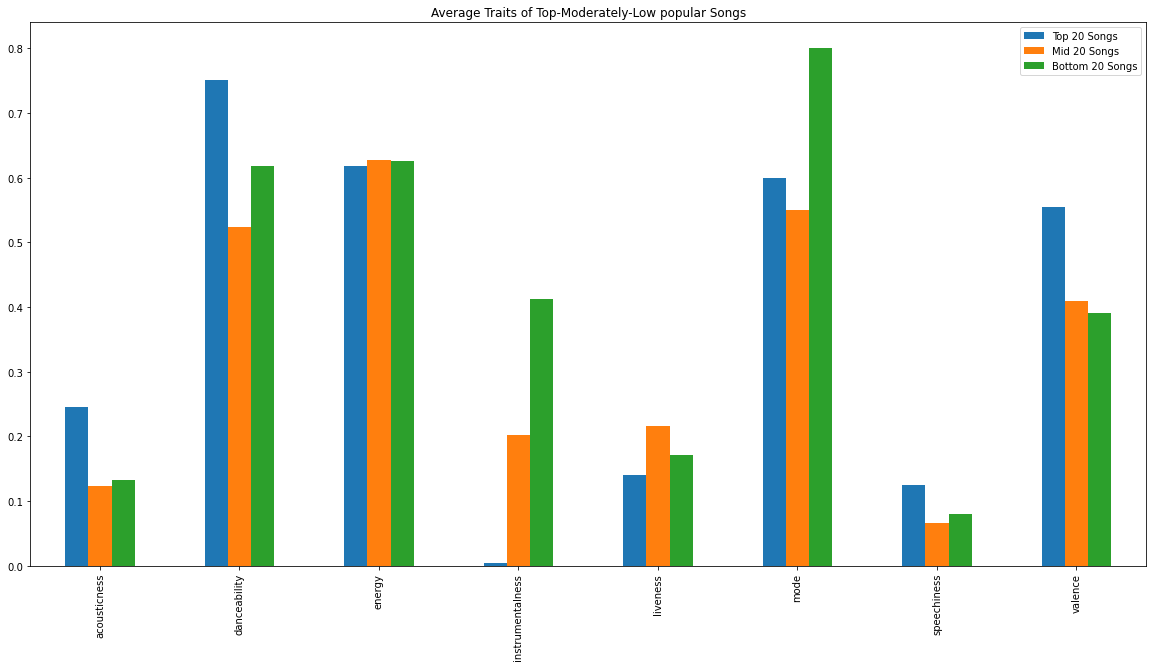

In [79]:
check = audiodf[audiodf['popularity'].between(audiodf['popularity'].quantile(0.45),audiodf['popularity'].quantile(0.55))]
check = check[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']].head(20)
check = check.T
mid_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Mid 20 Songs'])

check = audiodf.sort_values(by = 'popularity',ascending=False).head(20)[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']]
check = check.T
top_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Top 20 Songs'])

check = audiodf.sort_values(by = 'popularity',ascending=False).tail(20)[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']]
check = check.T
bottom_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Bottom 20 Songs'])

top_bottom = pd.concat([top_20,mid_20, bottom_20], axis = 1)

top_bottom.plot(title = 'Average Traits of Top-Moderately-Low popular Songs', figsize=(20,10),linewidth=2,kind = 'bar' )

Key Highlights: Popular songs have accousticness close to 